In [1]:
import stompy.model.delft.dflow_model as dfm
from stompy.grid import unstructured_grid
import xarray as xr
import matplotlib.pyplot as plt
import os
import numpy as np
from matplotlib import colors

from stompy.spatial import proj_utils
from stompy.spatial import interp_4d
import six

from stompy import utils

%matplotlib notebook

In [2]:
#model=dfm.DFlowModel.load("data_2d_2019_hybrid-v033")
model=dfm.DFlowModel.load("data_2d_2018_hybrid-v003")

In [ ]:
map_ds=model.map_dataset()

In [6]:
# Load the turbidity forcing data
#turb_ds=xr.open_dataset("../data/usgs_nwis/turbidity-2019-04-01-2019-08-01.nc")
turb_ds=xr.open_dataset("../data/usgs_nwis/turbidity-2018-04-01-2018-11-01.nc")

ll=np.c_[turb_ds.lon.values, turb_ds.lat.values]

utm=proj_utils.mapper('WGS84','EPSG:26910')(ll)

turb_ds['x']=turb_ds.lon.dims,utm[:,0]
turb_ds['y']=turb_ds.lat.dims,utm[:,1]


<IPython.core.display.Javascript object>


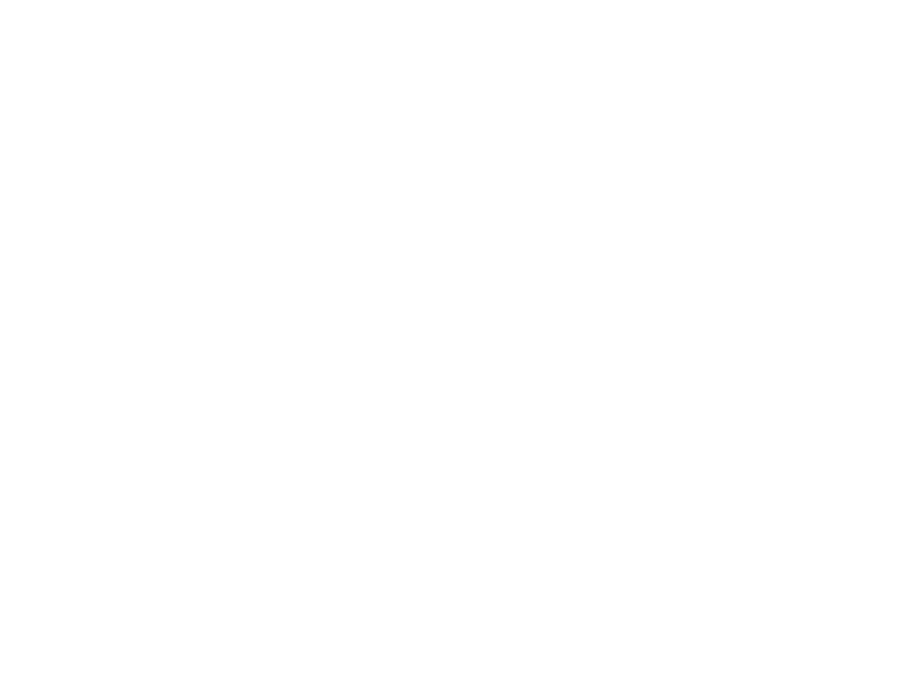

In [5]:
# Reconstructing just from wt_obs/wt
# hourly output. 5000+ steps.
tidx=1400

wt    =map_ds['mesh2d_wt'].isel(time=tidx).values
wt_obs=map_ds['mesh2d_wt_obs'].isel(time=tidx).values

min_wt=1e-7
scal=wt_obs/wt.clip(min_wt)
missing=wt<min_wt
scal[missing]=np.nan

g=map_ds.grid

fig,ax=plt.subplots(figsize=(9,7))
ax.axis('off')
ax.set_adjustable('datalim')
fig.subplots_adjust(left=0,right=1,top=1,bottom=0)

ccoll=g.plot_cells(values=scal,cmap='turbo',ax=ax,lw=0.5,edgecolor='face',mask=~missing)
g.plot_cells(mask=missing,color="0.8",ax=ax,lw=0.5,edgecolor='face')
cax=fig.add_axes([0.2,0.6,0.02,0.3])
plt.colorbar(ccoll,cax=cax)
ccoll.set_clim(1, 100)
ccoll.set_norm(colors.LogNorm(vmin=1,vmax=100))

# Show station locations
ax.plot( turb_ds.x, turb_ds.y, 'k.')
for i,site in enumerate(turb_ds.site.values):
    ax.text(turb_ds.x[i], turb_ds.y[i], site)

In [9]:
# Weighted extrapolation of advected observations:
six.moves.reload_module(interp_4d)
g=map_ds.grid
prepared=interp_4d.PreparedExtrapolation(g)


Checking finite geometry


Interpolation
--

Fallback: diffusion. We have continuous data at a number of locations, and
can diffuse that throughout the domain. DONE.

Advection & diffusion: use the advected field with weights as input to 
the same diffusion process.

Predictive model: Some sort of fit of turb ~ tauDecay1 + tauDecay2 + ???
Needs work.
 - would like this to have some spatial variability. I guess we'd get 
   coefficients at each station, and those coefficients could be extrapolated
   with diffusion. Unclear if there are issues with mixing coefficients -- i.e.
   if $a_i$ is a good set of parameters and $b_i$ is a good set, is an affine
   combination of them also good?
 - from the model output and monitoring stations we can fit per-station
   predictive models. The coefficients in these models could be extrapolated
   in space. For something like sediment this could be problematic. Might come up
   with a great model for turb ~ tau in the channel, and then the relationship in
   a nearby shallow is very different. Suggests that we really want a hierarchical
   model, where some coefficient are site-specific, but other coefficients are
   global, such as the role of local depth.
   
Hybrid model: predictive model where there is no data, advection/diffusion
  model where there is data.
  
Analysis
--

With each of those synthesize hourly snapshots at the time of cruises, from
which linear interpolated points can be extracted to match up with cruise
data. Test relative skill across the methods.

In [10]:
turb_ds

<xarray.Dataset>
Dimensions:     (time: 20516, site: 38)
Coordinates:
  * time        (time) datetime64[ns] 2018-04-01T07:00:00 ... 2018-10-31T23:4...
    lat         (site) float64 38.04 37.79 37.94 37.94 ... 38.33 38.34 38.34
    lon         (site) float64 -121.9 -121.3 -121.3 ... -121.7 -121.7 -121.7
    site_no     (site) object ...
    station_nm  (site) object ...
    parm_cd     object ...
Dimensions without coordinates: site
Data variables:
    turbidity   (site, time) float64 ...
    x           (site) float64 5.947e+05 6.49e+05 ... 6.161e+05 6.16e+05
    y           (site) float64 4.211e+06 4.183e+06 ... 4.244e+06 4.244e+06

In [18]:
# Load cruises, plot, then develop some machinery to predict at 
# cruise locations.
import pandas as pd

underway_dir="../data/usgs_underway"

def load_cruise(cruise_fn, 
                data_cols=['Turb (FNU) (EXO) HR'],
                obs_field='turb'):
    cruise_df=pd.read_csv(os.path.join(underway_dir,cruise_fn),
                          parse_dates=['Timestamp (PST)'],low_memory=False)

    cruise_df['time'] = cruise_df['Timestamp (PST)'] + np.timedelta64(8,'h')
    for lat_name in ['Latitude (Decimal Degrees)','Latitude (Decimal Degrees, NAD83)']:
        if lat_name in cruise_df.columns: break
    else: assert False
        
    for lon_name in ['Longitute (Decimal Degrees)','Longitude (Decimal Degrees, NAD83)']:
        if lon_name in cruise_df.columns: break
    else: assert False

    for fld in data_cols:
        if fld in cruise_df.columns:
            cruise_df[obs_field]=cruise_df[fld]
            break
            
    valid=cruise_df[obs_field].notnull() & cruise_df[lon_name].notnull() & cruise_df[lat_name].notnull()
    cruise_df=cruise_df[valid].copy()

    ll=cruise_df[ [lon_name, lat_name]].values
    
    xy=proj_utils.mapper('WGS84','EPSG:26910')(ll)
    bad_ll=~np.isfinite(xy[:,0])
    if np.any(bad_ll):
        print("Bad lon-lat in %s"%cruise_fn)
        print(ll[bad_ll])
    
    cruise_df['x']=xy[:,0]
    cruise_df['y']=xy[:,1]
    cruise_df=cruise_df[ ['time','x','y',obs_field] ]
    cruise_df['src']=cruise_fn
    return cruise_df

cruise_fns=["2018-08-23_Sample_data_ver.2.0.csv",
            "2018-09-05_Sample_data_ver.2.0.csv",
            "2018-09-13_Sample_data_ver.2.0.csv",
            "2018-10-04_Sample_data_ver.2.0.csv",
            "Delta Water Quality Mapping July 2018 High Resolution.csv",
            "Delta Water Quality Mapping May 2018 High Resolution.csv",
            "Delta Water Quality Mapping October 2018 High Resolution.csv",
           ]


cruise_dfs = [load_cruise(cruise_fn) for cruise_fn in cruise_fns]

cruise_df = pd.concat(cruise_dfs) # 389k points
cruise_df_thin = cruise_df.iloc[::30].copy() # 11.8k points
cruise_df_thin.describe() # 12k

,time,x,y,turb
count,11797,11797.000000,1.179700e+04,11797.000000
mean,2018-08-10 19:51:35.419174400,620033.499804,4.223600e+06,9.628741
min,2018-05-15 15:40:00,575551.965082,4.187875e+06,0.150000
25%,2018-07-24 16:06:00,614953.641796,4.212045e+06,3.400000
50%,2018-07-26 22:31:00,618675.305950,4.222487e+06,5.435000
75%,2018-10-17 17:24:00,629621.247045,4.234493e+06,9.250000
max,2018-10-20 00:26:00,646989.083885,4.270211e+06,148.600000
std,NaN,13601.456495,1.615455e+04,14.387928


In [19]:
# Diffusion:
class Predictor:
    grid=None
    
    def __init__(self,**kw):
        utils.set_keywords(self,kw)
        
    # def predict_map(self,t): SUBCLASS
    
    time_quant=np.timedelta64(1,'h')
    def predict_underway_from_map(self,boat_df):
        """
        Bin data by time interval, interpolate between successive
        predict_map output.
        """
        # Approach:
        # Quantize time (say, hourly), create map output for quantized time,
        # linearly interpolate. 
        data_dt = turb_ds.time.values[1] - turb_ds.time.values[0]
        assert self.time_quant>=data_dt
        
        binned = utils.floor_dt64(boat_df.time.values, self.time_quant)
        
        # Process each group
        t_last=None # cache last map since we can reuse most of the time.
        pred_map_last=None
        
        results=np.full(len(boat_df), np.nan, dtype=np.float64)
        
        boat_xy=boat_df[['x','y']].values
        
        for t_quant,idxs in utils.progress(utils.enumerate_groups(binned)):
            t0=t_quant
            t1=t0+self.time_quant
            print(f"Processing {t0} -- {t1}")
            if t0==t_last:
                pred_map_t0=pred_map_last
            else:
                pred_map_t0=self.predict_map(t0)
            pred_map_t1=self.predict_map(t1)
            
            sample_time=boat_df['time'].values[idxs]
            frac=(sample_time - t0)/self.time_quant
            cells=[self.grid.select_cells_nearest(boat_xy[i]) for i in idxs]
            val0=pred_map_t0[cells]
            val1=pred_map_t1[cells]
            
            results[idxs] = (1-frac)*val0 + frac*val1 
            
        return results
    
    def predict_underway(self,boat_df):
        """
        boat_df: data frame with x,y,time
        Generate predictions for each row.
        """
        return self.predict_underway_from_map(boat_df)


class PreparedPredictor(Predictor):
    prepared=None
    alpha=1e-5
        
    def get_prepared(self):
        if self.prepared is None:
            self.prepared=interp_4d.PreparedExtrapolation(self.grid, alpha=self.alpha)
        return self.prepared
    
class DiffusionPredictor(Predictor):
    turb_ds=None # monitoring dataset
    
    def predict_map(self,t):
        snap = self.turb_ds.sel(time=t,method='nearest')
        valid = np.isfinite(snap.turbidity.values)
        snap_v = snap.isel(site=valid)
        
        df=snap_v.to_dataframe() #[ 'x','y','turbidity']
        df=df[ ['x','y','turbidity'] ]
        df['weight']=1.0

        predicted=self.get_prepared().process(samples=df, value_col='turbidity')
            
        return predicted

        
class AdvDiffPredictor(PreparedPredictor):
    map_ds=None
    min_weight=0.0 # weights below this truncate to 0. mostly just to test getting back to diffusion.
    weight_exp=1.0 # exponent applied to weight.
    
    def __init__(self,**kw):
        super().__init__(**kw)
        if self.map_ds is not None and self.grid is None:
            self.grid = self.map_ds.grid # assumes it's a multiugrid.
            
    def predict_map(self,t):
        snap = self.map_ds.sel(time=t,method='nearest')
        wt    =snap['mesh2d_wt'].values.clip(0)
        wt = wt**self.weight_exp
        
        truncate=wt<self.min_weight
        wt_obs=snap['mesh2d_wt_obs'].values.clip(0)
        wt_obs[truncate]=0.0
        wt[truncate]=0.0
            
        result = self.get_prepared().process_raw(cell_weights=wt, cell_value_weights=wt_obs)
        return result

In [20]:
ad_predictor=AdvDiffPredictor(map_ds=map_ds,alpha=1e-5,min_weight=0.0)
result=ad_predictor.predict_underway(cruise_df_thin)
cruise_df_thin['pred_advdiff1e5'] = result

# For reference, straight diffusion from the observations is R=0.836, Amp=0.954


# R=0.831, Amp=0.978 for min_weight=0.9
# R=0.836, Amp=0.923 for min_weight=0.8
# R=0.837, Amp=0.824 for min_weight=0.5
# R=0.814, Amp=0.716 for 
#extrap_evaluate(cruise_df_thin, pred_col='pred_advdiff1e5',ref_col='turb', label='Adv-diff (FNU)')

# These all had a bug I think.
# Similarly bad. R=0.535, Amp = 0.691
#extrap_evaluate(cruise_df_thin, pred_col='pred_advdiff5e5',ref_col='turb', label='Adv-diff (FNU)')
# R=0.545, Amp=0.891
#extrap_evaluate(cruise_df_thin, pred_col='pred_advdiff5e5_m90',ref_col='turb', label='Adv-diff (FNU)')

Processing 2018-05-15T15:00:00 -- 2018-05-15T16:00:00
Checking finite geometry


INFO:utils:1


Processing 2018-05-15T16:00:00 -- 2018-05-15T17:00:00
Processing 2018-05-15T17:00:00 -- 2018-05-15T18:00:00
Processing 2018-05-15T18:00:00 -- 2018-05-15T19:00:00
Processing 2018-05-15T19:00:00 -- 2018-05-15T20:00:00
Processing 2018-05-15T20:00:00 -- 2018-05-15T21:00:00
Processing 2018-05-15T21:00:00 -- 2018-05-15T22:00:00
Processing 2018-05-15T22:00:00 -- 2018-05-15T23:00:00
Processing 2018-05-15T23:00:00 -- 2018-05-16T00:00:00
Processing 2018-05-16T00:00:00 -- 2018-05-16T01:00:00


INFO:utils:10


Processing 2018-05-16T15:00:00 -- 2018-05-16T16:00:00
Processing 2018-05-16T16:00:00 -- 2018-05-16T17:00:00
Processing 2018-05-16T17:00:00 -- 2018-05-16T18:00:00
Processing 2018-05-16T18:00:00 -- 2018-05-16T19:00:00
Processing 2018-05-16T19:00:00 -- 2018-05-16T20:00:00
Processing 2018-05-16T20:00:00 -- 2018-05-16T21:00:00
Processing 2018-05-16T21:00:00 -- 2018-05-16T22:00:00
Processing 2018-05-16T22:00:00 -- 2018-05-16T23:00:00
Processing 2018-05-16T23:00:00 -- 2018-05-17T00:00:00


INFO:utils:19


Processing 2018-05-17T00:00:00 -- 2018-05-17T01:00:00
Processing 2018-05-17T15:00:00 -- 2018-05-17T16:00:00
Processing 2018-05-17T16:00:00 -- 2018-05-17T17:00:00
Processing 2018-05-17T17:00:00 -- 2018-05-17T18:00:00
Processing 2018-05-17T18:00:00 -- 2018-05-17T19:00:00
Processing 2018-05-17T19:00:00 -- 2018-05-17T20:00:00
Processing 2018-05-17T20:00:00 -- 2018-05-17T21:00:00
Processing 2018-05-17T21:00:00 -- 2018-05-17T22:00:00


INFO:utils:27


Processing 2018-05-17T22:00:00 -- 2018-05-17T23:00:00
Processing 2018-05-17T23:00:00 -- 2018-05-18T00:00:00
Processing 2018-05-18T00:00:00 -- 2018-05-18T01:00:00
Processing 2018-07-24T14:00:00 -- 2018-07-24T15:00:00
Processing 2018-07-24T15:00:00 -- 2018-07-24T16:00:00
Processing 2018-07-24T16:00:00 -- 2018-07-24T17:00:00
Processing 2018-07-24T17:00:00 -- 2018-07-24T18:00:00
Processing 2018-07-24T18:00:00 -- 2018-07-24T19:00:00
Processing 2018-07-24T19:00:00 -- 2018-07-24T20:00:00


INFO:utils:36


Processing 2018-07-24T20:00:00 -- 2018-07-24T21:00:00
Processing 2018-07-24T21:00:00 -- 2018-07-24T22:00:00
Processing 2018-07-24T22:00:00 -- 2018-07-24T23:00:00
Processing 2018-07-24T23:00:00 -- 2018-07-25T00:00:00
Processing 2018-07-25T00:00:00 -- 2018-07-25T01:00:00
Processing 2018-07-25T01:00:00 -- 2018-07-25T02:00:00
Processing 2018-07-25T02:00:00 -- 2018-07-25T03:00:00
Processing 2018-07-25T14:00:00 -- 2018-07-25T15:00:00
Processing 2018-07-25T15:00:00 -- 2018-07-25T16:00:00


INFO:utils:45


Processing 2018-07-25T16:00:00 -- 2018-07-25T17:00:00
Processing 2018-07-25T17:00:00 -- 2018-07-25T18:00:00
Processing 2018-07-25T18:00:00 -- 2018-07-25T19:00:00
Processing 2018-07-25T19:00:00 -- 2018-07-25T20:00:00
Processing 2018-07-25T20:00:00 -- 2018-07-25T21:00:00
Processing 2018-07-25T21:00:00 -- 2018-07-25T22:00:00
Processing 2018-07-25T22:00:00 -- 2018-07-25T23:00:00
Processing 2018-07-25T23:00:00 -- 2018-07-26T00:00:00
Processing 2018-07-26T00:00:00 -- 2018-07-26T01:00:00


INFO:utils:54


Processing 2018-07-26T15:00:00 -- 2018-07-26T16:00:00
Processing 2018-07-26T16:00:00 -- 2018-07-26T17:00:00
Processing 2018-07-26T17:00:00 -- 2018-07-26T18:00:00
Processing 2018-07-26T18:00:00 -- 2018-07-26T19:00:00
Processing 2018-07-26T19:00:00 -- 2018-07-26T20:00:00
Processing 2018-07-26T20:00:00 -- 2018-07-26T21:00:00
Processing 2018-07-26T21:00:00 -- 2018-07-26T22:00:00
Processing 2018-07-26T22:00:00 -- 2018-07-26T23:00:00
Processing 2018-07-26T23:00:00 -- 2018-07-27T00:00:00


INFO:utils:63


Processing 2018-08-23T16:00:00 -- 2018-08-23T17:00:00
Processing 2018-08-23T17:00:00 -- 2018-08-23T18:00:00
Processing 2018-08-23T18:00:00 -- 2018-08-23T19:00:00
Processing 2018-08-23T19:00:00 -- 2018-08-23T20:00:00
Processing 2018-08-23T20:00:00 -- 2018-08-23T21:00:00
Processing 2018-08-23T21:00:00 -- 2018-08-23T22:00:00
Processing 2018-08-23T22:00:00 -- 2018-08-23T23:00:00
Processing 2018-08-23T23:00:00 -- 2018-08-24T00:00:00
Processing 2018-08-24T00:00:00 -- 2018-08-24T01:00:00


INFO:utils:72


Processing 2018-09-05T15:00:00 -- 2018-09-05T16:00:00
Processing 2018-09-05T16:00:00 -- 2018-09-05T17:00:00
Processing 2018-09-05T17:00:00 -- 2018-09-05T18:00:00
Processing 2018-09-05T18:00:00 -- 2018-09-05T19:00:00
Processing 2018-09-05T19:00:00 -- 2018-09-05T20:00:00
Processing 2018-09-05T20:00:00 -- 2018-09-05T21:00:00
Processing 2018-09-05T21:00:00 -- 2018-09-05T22:00:00
Processing 2018-09-05T22:00:00 -- 2018-09-05T23:00:00
Processing 2018-09-05T23:00:00 -- 2018-09-06T00:00:00


INFO:utils:81


Processing 2018-09-13T18:00:00 -- 2018-09-13T19:00:00
Processing 2018-09-13T19:00:00 -- 2018-09-13T20:00:00
Processing 2018-09-13T20:00:00 -- 2018-09-13T21:00:00
Processing 2018-09-13T21:00:00 -- 2018-09-13T22:00:00
Processing 2018-09-13T22:00:00 -- 2018-09-13T23:00:00
Processing 2018-09-13T23:00:00 -- 2018-09-14T00:00:00
Processing 2018-09-14T00:00:00 -- 2018-09-14T01:00:00
Processing 2018-10-04T16:00:00 -- 2018-10-04T17:00:00
Processing 2018-10-04T17:00:00 -- 2018-10-04T18:00:00


INFO:utils:90


Processing 2018-10-04T18:00:00 -- 2018-10-04T19:00:00
Processing 2018-10-04T19:00:00 -- 2018-10-04T20:00:00
Processing 2018-10-17T16:00:00 -- 2018-10-17T17:00:00
Processing 2018-10-17T17:00:00 -- 2018-10-17T18:00:00
Processing 2018-10-17T18:00:00 -- 2018-10-17T19:00:00
Processing 2018-10-17T19:00:00 -- 2018-10-17T20:00:00
Processing 2018-10-17T20:00:00 -- 2018-10-17T21:00:00
Processing 2018-10-17T21:00:00 -- 2018-10-17T22:00:00
Processing 2018-10-17T22:00:00 -- 2018-10-17T23:00:00


INFO:utils:99


Processing 2018-10-17T23:00:00 -- 2018-10-18T00:00:00
Processing 2018-10-18T00:00:00 -- 2018-10-18T01:00:00
Processing 2018-10-18T01:00:00 -- 2018-10-18T02:00:00
Processing 2018-10-18T15:00:00 -- 2018-10-18T16:00:00
Processing 2018-10-18T16:00:00 -- 2018-10-18T17:00:00
Processing 2018-10-18T17:00:00 -- 2018-10-18T18:00:00
Processing 2018-10-18T18:00:00 -- 2018-10-18T19:00:00
Processing 2018-10-18T19:00:00 -- 2018-10-18T20:00:00
Processing 2018-10-18T20:00:00 -- 2018-10-18T21:00:00


INFO:utils:108


Processing 2018-10-18T21:00:00 -- 2018-10-18T22:00:00
Processing 2018-10-18T22:00:00 -- 2018-10-18T23:00:00
Processing 2018-10-18T23:00:00 -- 2018-10-19T00:00:00
Processing 2018-10-19T14:00:00 -- 2018-10-19T15:00:00
Processing 2018-10-19T15:00:00 -- 2018-10-19T16:00:00
Processing 2018-10-19T16:00:00 -- 2018-10-19T17:00:00
Processing 2018-10-19T17:00:00 -- 2018-10-19T18:00:00
Processing 2018-10-19T18:00:00 -- 2018-10-19T19:00:00
Processing 2018-10-19T19:00:00 -- 2018-10-19T20:00:00


INFO:utils:117


Processing 2018-10-19T20:00:00 -- 2018-10-19T21:00:00
Processing 2018-10-19T21:00:00 -- 2018-10-19T22:00:00
Processing 2018-10-19T22:00:00 -- 2018-10-19T23:00:00
Processing 2018-10-19T23:00:00 -- 2018-10-20T00:00:00
Processing 2018-10-20T00:00:00 -- 2018-10-20T01:00:00


<IPython.core.display.Javascript object>


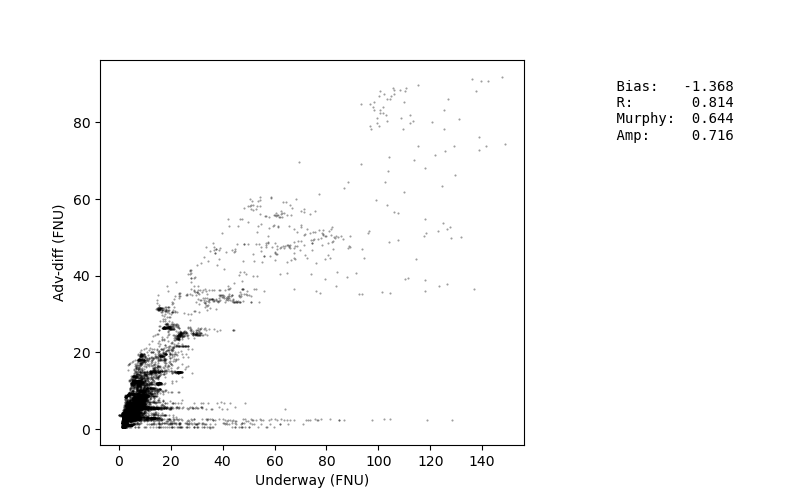

In [23]:
# even with alpha=5e-5, this is very close to the diffusion only. R is slightly lower, Amp slightly higher.
extrap_evaluate(cruise_df_thin, pred_col='pred_advdiff1e5',ref_col='turb', label='Adv-diff (FNU)')

In [100]:
diff_predictor=DiffusionPredictor(grid=map_ds.grid, turb_ds=turb_ds)
result=diff_predictor.predict_underway(cruise_df_thin)
cruise_df_thin['pred_diff'] = result

Processing 2018-05-15T15:00:00 -- 2018-05-15T16:00:00
Checking finite geometry


INFO:utils:1


Processing 2018-05-15T16:00:00 -- 2018-05-15T17:00:00
Processing 2018-05-15T17:00:00 -- 2018-05-15T18:00:00
Processing 2018-05-15T18:00:00 -- 2018-05-15T19:00:00
Processing 2018-05-15T19:00:00 -- 2018-05-15T20:00:00
Processing 2018-05-15T20:00:00 -- 2018-05-15T21:00:00
Processing 2018-05-15T21:00:00 -- 2018-05-15T22:00:00


INFO:utils:7


Processing 2018-05-15T22:00:00 -- 2018-05-15T23:00:00
Processing 2018-05-15T23:00:00 -- 2018-05-16T00:00:00
Processing 2018-05-16T00:00:00 -- 2018-05-16T01:00:00
Processing 2018-05-16T15:00:00 -- 2018-05-16T16:00:00
Processing 2018-05-16T16:00:00 -- 2018-05-16T17:00:00


INFO:utils:12


Processing 2018-05-16T17:00:00 -- 2018-05-16T18:00:00
Processing 2018-05-16T18:00:00 -- 2018-05-16T19:00:00
Processing 2018-05-16T19:00:00 -- 2018-05-16T20:00:00
Processing 2018-05-16T20:00:00 -- 2018-05-16T21:00:00


INFO:utils:16


Processing 2018-05-16T21:00:00 -- 2018-05-16T22:00:00
Processing 2018-05-16T22:00:00 -- 2018-05-16T23:00:00
Processing 2018-05-16T23:00:00 -- 2018-05-17T00:00:00
Processing 2018-05-17T00:00:00 -- 2018-05-17T01:00:00
Processing 2018-05-17T15:00:00 -- 2018-05-17T16:00:00


INFO:utils:21


Processing 2018-05-17T16:00:00 -- 2018-05-17T17:00:00
Processing 2018-05-17T17:00:00 -- 2018-05-17T18:00:00
Processing 2018-05-17T18:00:00 -- 2018-05-17T19:00:00


INFO:utils:24


Processing 2018-05-17T19:00:00 -- 2018-05-17T20:00:00


INFO:utils:25


Processing 2018-05-17T20:00:00 -- 2018-05-17T21:00:00
Processing 2018-05-17T21:00:00 -- 2018-05-17T22:00:00
Processing 2018-05-17T22:00:00 -- 2018-05-17T23:00:00


INFO:utils:28


Processing 2018-05-17T23:00:00 -- 2018-05-18T00:00:00
Processing 2018-05-18T00:00:00 -- 2018-05-18T01:00:00
Processing 2018-07-24T14:00:00 -- 2018-07-24T15:00:00
Processing 2018-07-24T15:00:00 -- 2018-07-24T16:00:00
Processing 2018-07-24T16:00:00 -- 2018-07-24T17:00:00


INFO:utils:33


Processing 2018-07-24T17:00:00 -- 2018-07-24T18:00:00
Processing 2018-07-24T18:00:00 -- 2018-07-24T19:00:00
Processing 2018-07-24T19:00:00 -- 2018-07-24T20:00:00
Processing 2018-07-24T20:00:00 -- 2018-07-24T21:00:00


INFO:utils:37


Processing 2018-07-24T21:00:00 -- 2018-07-24T22:00:00
Processing 2018-07-24T22:00:00 -- 2018-07-24T23:00:00


INFO:utils:39


Processing 2018-07-24T23:00:00 -- 2018-07-25T00:00:00


INFO:utils:40


Processing 2018-07-25T00:00:00 -- 2018-07-25T01:00:00
Processing 2018-07-25T01:00:00 -- 2018-07-25T02:00:00
Processing 2018-07-25T02:00:00 -- 2018-07-25T03:00:00
Processing 2018-07-25T14:00:00 -- 2018-07-25T15:00:00
Processing 2018-07-25T15:00:00 -- 2018-07-25T16:00:00


INFO:utils:45


Processing 2018-07-25T16:00:00 -- 2018-07-25T17:00:00
Processing 2018-07-25T17:00:00 -- 2018-07-25T18:00:00
Processing 2018-07-25T18:00:00 -- 2018-07-25T19:00:00
Processing 2018-07-25T19:00:00 -- 2018-07-25T20:00:00


INFO:utils:49


Processing 2018-07-25T20:00:00 -- 2018-07-25T21:00:00
Processing 2018-07-25T21:00:00 -- 2018-07-25T22:00:00
Processing 2018-07-25T22:00:00 -- 2018-07-25T23:00:00
Processing 2018-07-25T23:00:00 -- 2018-07-26T00:00:00
Processing 2018-07-26T00:00:00 -- 2018-07-26T01:00:00
Processing 2018-07-26T14:00:00 -- 2018-07-26T15:00:00


INFO:utils:55


Processing 2018-07-26T15:00:00 -- 2018-07-26T16:00:00
Processing 2018-07-26T16:00:00 -- 2018-07-26T17:00:00
Processing 2018-07-26T17:00:00 -- 2018-07-26T18:00:00
Processing 2018-07-26T18:00:00 -- 2018-07-26T19:00:00
Processing 2018-07-26T19:00:00 -- 2018-07-26T20:00:00
Processing 2018-07-26T20:00:00 -- 2018-07-26T21:00:00


INFO:utils:61


Processing 2018-07-26T21:00:00 -- 2018-07-26T22:00:00
Processing 2018-07-26T22:00:00 -- 2018-07-26T23:00:00
Processing 2018-07-26T23:00:00 -- 2018-07-27T00:00:00
Processing 2018-08-23T16:00:00 -- 2018-08-23T17:00:00
Processing 2018-08-23T17:00:00 -- 2018-08-23T18:00:00
Processing 2018-08-23T18:00:00 -- 2018-08-23T19:00:00
Processing 2018-08-23T19:00:00 -- 2018-08-23T20:00:00
Processing 2018-08-23T20:00:00 -- 2018-08-23T21:00:00
Processing 2018-08-23T21:00:00 -- 2018-08-23T22:00:00


INFO:utils:70


Processing 2018-08-23T22:00:00 -- 2018-08-23T23:00:00
Processing 2018-08-23T23:00:00 -- 2018-08-24T00:00:00
Processing 2018-08-24T00:00:00 -- 2018-08-24T01:00:00
Processing 2018-09-05T15:00:00 -- 2018-09-05T16:00:00
Processing 2018-09-05T16:00:00 -- 2018-09-05T17:00:00
Processing 2018-09-05T17:00:00 -- 2018-09-05T18:00:00
Processing 2018-09-05T18:00:00 -- 2018-09-05T19:00:00
Processing 2018-09-05T19:00:00 -- 2018-09-05T20:00:00
Processing 2018-09-05T20:00:00 -- 2018-09-05T21:00:00


INFO:utils:79


Processing 2018-09-05T21:00:00 -- 2018-09-05T22:00:00
Processing 2018-09-05T22:00:00 -- 2018-09-05T23:00:00
Processing 2018-09-05T23:00:00 -- 2018-09-06T00:00:00
Processing 2018-09-13T18:00:00 -- 2018-09-13T19:00:00
Processing 2018-09-13T19:00:00 -- 2018-09-13T20:00:00
Processing 2018-09-13T20:00:00 -- 2018-09-13T21:00:00
Processing 2018-09-13T21:00:00 -- 2018-09-13T22:00:00
Processing 2018-09-13T22:00:00 -- 2018-09-13T23:00:00


INFO:utils:87


Processing 2018-09-13T23:00:00 -- 2018-09-14T00:00:00
Processing 2018-09-14T00:00:00 -- 2018-09-14T01:00:00
Processing 2018-10-04T16:00:00 -- 2018-10-04T17:00:00
Processing 2018-10-04T17:00:00 -- 2018-10-04T18:00:00
Processing 2018-10-04T18:00:00 -- 2018-10-04T19:00:00
Processing 2018-10-04T19:00:00 -- 2018-10-04T20:00:00
Processing 2018-10-17T16:00:00 -- 2018-10-17T17:00:00
Processing 2018-10-17T17:00:00 -- 2018-10-17T18:00:00


INFO:utils:95


Processing 2018-10-17T18:00:00 -- 2018-10-17T19:00:00
Processing 2018-10-17T19:00:00 -- 2018-10-17T20:00:00
Processing 2018-10-17T20:00:00 -- 2018-10-17T21:00:00
Processing 2018-10-17T21:00:00 -- 2018-10-17T22:00:00
Processing 2018-10-17T22:00:00 -- 2018-10-17T23:00:00
Processing 2018-10-17T23:00:00 -- 2018-10-18T00:00:00
Processing 2018-10-18T00:00:00 -- 2018-10-18T01:00:00


INFO:utils:102


Processing 2018-10-18T01:00:00 -- 2018-10-18T02:00:00
Processing 2018-10-18T15:00:00 -- 2018-10-18T16:00:00
Processing 2018-10-18T16:00:00 -- 2018-10-18T17:00:00
Processing 2018-10-18T17:00:00 -- 2018-10-18T18:00:00
Processing 2018-10-18T18:00:00 -- 2018-10-18T19:00:00
Processing 2018-10-18T19:00:00 -- 2018-10-18T20:00:00
Processing 2018-10-18T20:00:00 -- 2018-10-18T21:00:00
Processing 2018-10-18T21:00:00 -- 2018-10-18T22:00:00


INFO:utils:110


Processing 2018-10-18T22:00:00 -- 2018-10-18T23:00:00
Processing 2018-10-18T23:00:00 -- 2018-10-19T00:00:00
Processing 2018-10-19T14:00:00 -- 2018-10-19T15:00:00
Processing 2018-10-19T15:00:00 -- 2018-10-19T16:00:00
Processing 2018-10-19T16:00:00 -- 2018-10-19T17:00:00
Processing 2018-10-19T17:00:00 -- 2018-10-19T18:00:00
Processing 2018-10-19T18:00:00 -- 2018-10-19T19:00:00
Processing 2018-10-19T19:00:00 -- 2018-10-19T20:00:00
Processing 2018-10-19T20:00:00 -- 2018-10-19T21:00:00


INFO:utils:119


Processing 2018-10-19T21:00:00 -- 2018-10-19T22:00:00
Processing 2018-10-19T22:00:00 -- 2018-10-19T23:00:00
Processing 2018-10-19T23:00:00 -- 2018-10-20T00:00:00
Processing 2018-10-20T00:00:00 -- 2018-10-20T01:00:00


<IPython.core.display.Javascript object>


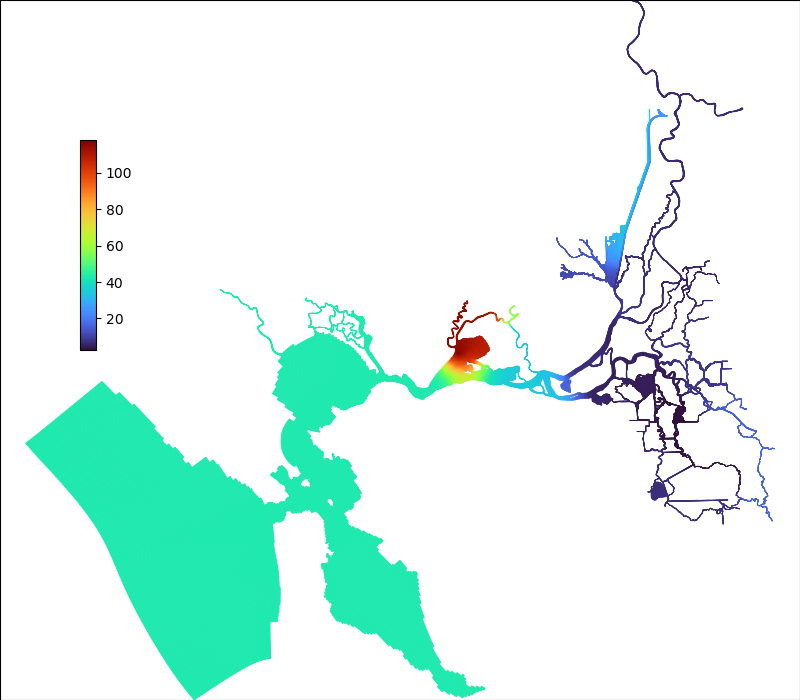

In [98]:
diff_pred=diff_predictor.predict_map(np.datetime64('2018-06-01'))

fig,ax=plt.subplots(figsize=(8,7))
ax.set_adjustable('datalim')
ax.set_position([0,0,1,1])
cax=fig.add_axes([0.1,0.5,0.02,0.3])
ccoll=map_ds.grid.plot_cells(values=diff_pred,cmap='turbo',lw=0.5,edgecolor='face',ax=ax)
plt.colorbar(ccoll,cax=cax)

<IPython.core.display.Javascript object>


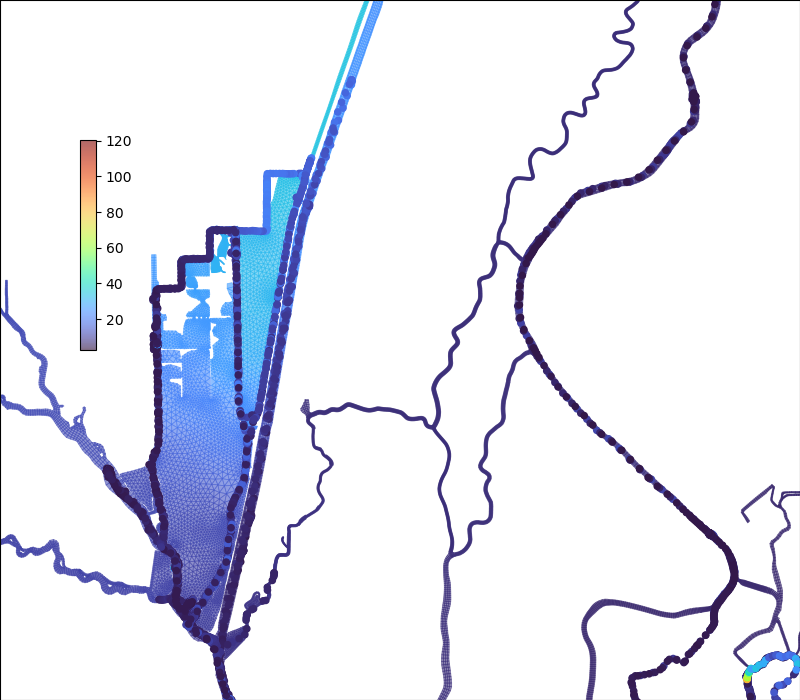

In [74]:
fig,ax=plt.subplots(figsize=(8,7))
ax.set_adjustable('datalim')
ax.set_position([0,0,1,1])
cax=fig.add_axes([0.1,0.5,0.02,0.3])
ccoll=map_ds.grid.plot_cells(values=diff_pred,cmap='turbo',lw=0.5,edgecolor='face',ax=ax,
                            alpha=0.6)

scat=ax.scatter(cruise_df_thin.x, cruise_df_thin.y, 20, cruise_df_thin['turb'], cmap='turbo')
plt.colorbar(ccoll,cax=cax)

In [22]:
from stompy.model import data_comparison

def extrap_evaluate(df, pred_col, ref_col, label='Predicted'):
    # How does straight up diffusion do?
    fig,(ax,ax_txt)=plt.subplots(1,2,figsize=(8,5), width_ratios=[1,0.33])

    ax.plot( df[ref_col], df[pred_col], 'k.',ms=1.0, alpha=0.4)
    ax.set_xlabel('Underway (FNU)')
    ax.set_ylabel(label)

    metrics = data_comparison.calc_metrics(df[pred_col], 
                                           df[ref_col])
    text=f"""
    Bias:   {metrics['bias']: .3f}
    R:      {metrics['r']: .3f}
    Murphy: {metrics['murphy']: .3f}
    Amp:    {metrics['amp']: .3f}"""
    ax_txt.axis('off')
    ax_txt.text(0.02,0.99,text,transform=ax_txt.transAxes,va='top',fontfamily='monospace')

<IPython.core.display.Javascript object>


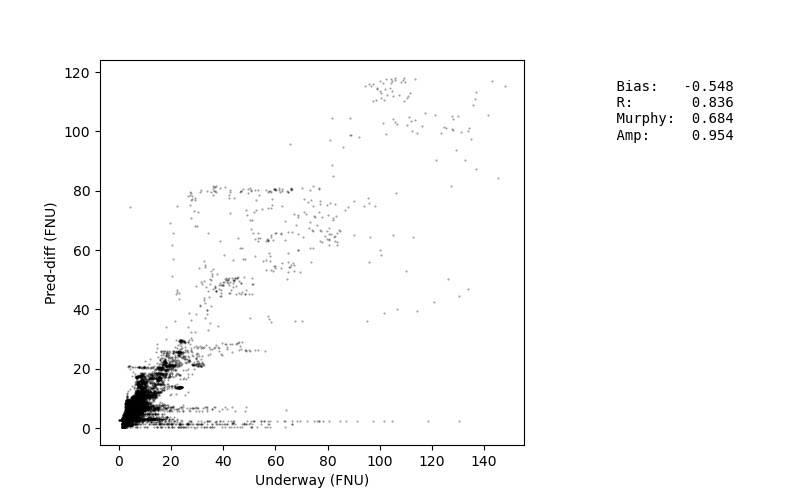

In [146]:
extrap_evaluate(cruise_df_thin, pred_col='pred_diff',ref_col='turb', label='Pred-diff (FNU)')


<IPython.core.display.Javascript object>


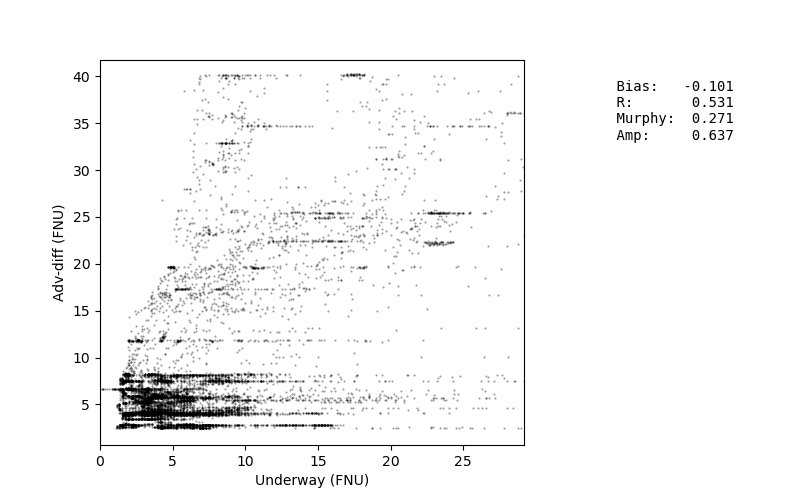

In [149]:
extrap_evaluate(cruise_df_thin, pred_col='pred_advdiff1e5',ref_col='turb', label='Adv-diff (FNU)')
